# Preparing the data for the analysis

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np

xr.set_options(display_expand_attrs=False, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

In [2]:
# This cell stores the variables for the rest of the script, so it is easier to change if needed
data_file_path = '../../../results/batch/run_ds_18_07.nc'

First, we have to load the data that came as an output of the model. Variables of interest are stored in a netcdf file (.nc), that we will load as a dataset, and convert to a pandas dataframe. 

In [48]:
variables = ['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact', 'dsk_tot_eq_dsk_total_impact',
       'fund_tot_eq_monetary_impact', 'fund_tot_eq_total_deaths',
       'fund_tot_eq_fund_total_impact', 'fund_tot_total_damage',
       'witness_tot_eq_witness_total_impact', 'time',
       'temperature_change', 'total_population', 'extra_extra_exponent',
       'extra_extra_normalisation_constant', 'extra_extra_gdp_modifyer',
       'total_radiative_forcing', 
       'gross_domestic_product_nominal', 'population_35_regions', 
       'average_disposable_income_per_capita']

damage_variables = ['define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact', 'dsk_tot_eq_dsk_total_impact',
       'fund_tot_eq_monetary_impact', 'fund_tot_total_damage',
       'fund_tot_eq_fund_total_impact', 'witness_tot_eq_witness_total_impact']      

ds = xr.open_dataset(data_file_path)
df = ds[variables].to_dataframe().reset_index()
df = df.rename(columns={'extra_extra_gdp_modifyer': 'coef'})


We now have a dataframe : 

In [49]:
df

,Run,time,REGIONS 35 I,define_tot_eq_define_total_impact,dice_tot_eq_dice_total_impact,dsk_tot_eq_dsk_total_impact,fund_tot_eq_monetary_impact,fund_tot_eq_total_deaths,fund_tot_eq_fund_total_impact,fund_tot_total_damage,witness_tot_eq_witness_total_impact,temperature_change,total_population,extra_extra_exponent,extra_extra_normalisation_constant,coef,total_radiative_forcing,gross_domestic_product_nominal,population_35_regions,average_disposable_income_per_capita
0,0,2005.0,AUSTRIA,inf,inf,NaN,NaN,NaN,NaN,NaN,inf,0.845000,6.541007e+09,-2.120837,14345.919289,inf,1.714491,3.786850e+05,8.253656e+06,0.000000
1,0,2005.0,BELGIUM,4.552596e+02,5.499544e+02,0.0,1.379671e+09,5.746519e+06,1.379671e+09,4.973581e+06,9.292477e+02,0.845000,6.541007e+09,-2.120837,14345.919289,0.484972,1.714491,4.580816e+05,1.054688e+07,24767.399895
2,0,2005.0,BULGARIA,3.365703e+02,4.065775e+02,0.0,2.799410e+08,5.009851e+01,2.799410e+08,8.615126e+05,6.869865e+02,0.845000,6.541007e+09,-2.120837,14345.919289,3.328578,1.714491,4.934207e+04,7.686964e+06,4290.060541
3,0,2005.0,CROATIA,1.805931e+02,2.181568e+02,0.0,2.565073e+08,2.853332e+01,2.565073e+08,1.519235e+06,3.686154e+02,0.845000,6.541007e+09,-2.120837,14345.919289,1.784685,1.714491,4.937873e+04,4.378066e+06,7565.730576
4,0,2005.0,CYPRUS,3.437053e+01,4.151966e+01,0.0,9.993271e+07,5.360278e+05,9.993271e+07,3.055627e+06,7.015501e+01,0.845000,6.541007e+09,-2.120837,14345.919289,0.828186,1.714491,2.025158e+04,1.027657e+06,15217.411656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29395,14,2060.0,INDIA,1.082256e+05,5.521826e+04,0.0,1.097148e+10,2.813391e+04,1.097148e+10,1.846274e+05,9.751358e+04,2.301589,8.386047e+09,-2.424749,21416.325501,0.746499,4.301696,4.027580e+06,1.541035e+09,742.585934
29396,14,2060.0,LATAM,2.632613e+05,1.343197e+05,0.0,3.113982e+10,4.678880e+03,3.113982e+10,2.172643e+06,2.372041e+05,2.301589,8.386047e+09,-2.424749,21416.325501,0.912993,4.301696,8.010561e+06,4.004570e+08,10750.534066
29397,14,2060.0,RUSSIA,5.946163e+05,3.033819e+05,0.0,2.869332e+10,6.452855e+02,2.869332e+10,1.450490e+07,5.357622e+05,2.301589,8.386047e+09,-2.424749,21416.325501,1.053842,4.301696,1.567490e+07,1.373280e+08,72197.949740
29398,14,2060.0,USMCA,3.108425e+06,1.585964e+06,0.0,1.075003e+11,4.163049e+03,1.075003e+11,1.982213e+07,2.800758e+06,2.301589,8.386047e+09,-2.424749,21416.325501,1.078673,4.301696,8.005607e+07,4.746416e+08,98352.078177


### Cleaning the dataset from coef outliers

We now compute the spatial equity coefficient, which takes the form : 

$$ \text{coef} = (\frac{y_{t,r}}{y_0})^\beta $$

<Axes: xlabel='gross_domestic_product_nominal', ylabel='coef'>

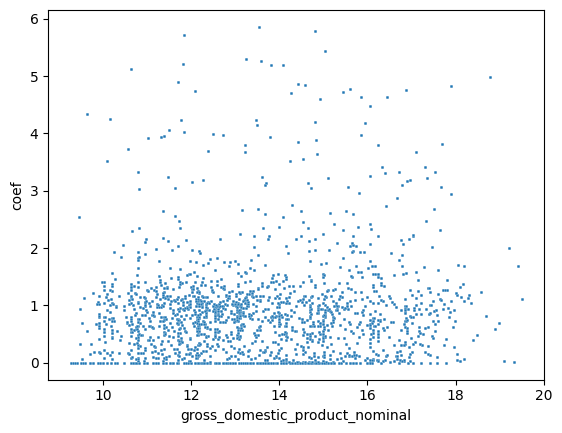

In [50]:
sns.scatterplot(data=df[df['coef']<6], y='coef', x=np.log(df['gross_domestic_product_nominal']), s=3)

In [63]:
df_no_outliers['coef'].quantile(0.95)

3.224488395372075

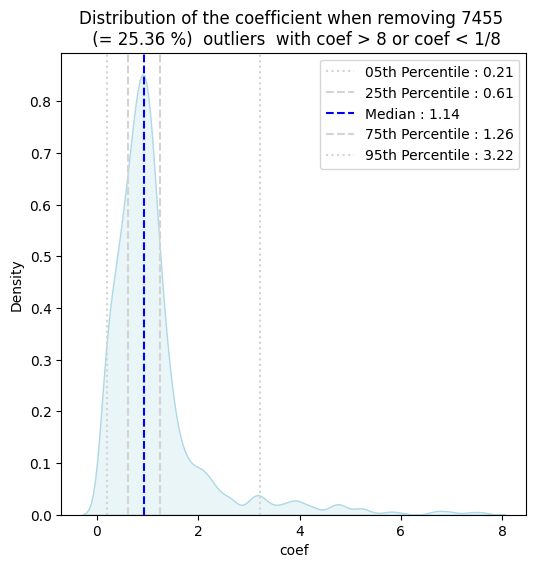

In [67]:
fig, ax = plt.subplots(figsize=(6, 6))

original_shape = df.shape[0]
coef_threshold = 8
df_outliers = df[(df['coef'] > coef_threshold) | (df['coef'] < 1/coef_threshold)]
df_no_outliers = df[(df['coef'] < coef_threshold) & (df['coef'] > 1/coef_threshold)]
sns.kdeplot(data=df_no_outliers, x='coef', ax=ax, color='lightblue', fill=True)

plt.axvline(df_no_outliers['coef'].quantile(0.05), color='lightgrey', linestyle='dotted', label=f'05th Percentile : {df_no_outliers["coef"].quantile(0.05):.2f}')
plt.axvline(df_no_outliers['coef'].quantile(0.25), color='lightgrey', linestyle='--', label=f'25th Percentile : {df_no_outliers["coef"].quantile(0.25):.2f}')
plt.axvline(df_no_outliers['coef'].median(), color='blue', linestyle='--', label=f'Median : {df_no_outliers["coef"].mean():.2f}')
plt.axvline(df_no_outliers['coef'].quantile(0.75), color='lightgrey', linestyle='--', label=f'75th Percentile : {df_no_outliers["coef"].quantile(0.75):.2f}')
plt.axvline(df_no_outliers['coef'].quantile(0.95), color='lightgrey', linestyle='dotted', label=f'95th Percentile : {df_no_outliers["coef"].quantile(0.95):.2f}')



plt.title(f'Distribution of the coefficient when removing {df_outliers.shape[0]} \n (= {100*df_outliers.shape[0]/original_shape:.2f} %)  outliers  with coef > {coef_threshold} or coef < 1/{coef_threshold}')
plt.legend()
plt.show()

In [72]:
df_no_outliers.columns

Index(['Run', 'time', 'REGIONS 35 I', 'define_tot_eq_define_total_impact',
       'dice_tot_eq_dice_total_impact', 'dsk_tot_eq_dsk_total_impact',
       'fund_tot_eq_monetary_impact', 'fund_tot_eq_total_deaths',
       'fund_tot_eq_fund_total_impact', 'fund_tot_total_damage',
       'witness_tot_eq_witness_total_impact', 'temperature_change',
       'total_population', 'extra_extra_exponent',
       'extra_extra_normalisation_constant', 'coef', 'total_radiative_forcing',
       'gross_domestic_product_nominal', 'population_35_regions',
       'average_disposable_income_per_capita'],
      dtype='object')

In [75]:
variables_to_show = ['coef', 'temperature_change']

description_table = df_no_outliers[variables_to_show].describe()

latex_table = description_table.to_latex()

with open('../../../../Memoire/results/description_table.tex', 'w') as f:
    f.write(latex_table)

description_table

,coef,temperature_change
count,21945.000000,21945.000000
mean,1.143808,1.508060
std,1.006845,0.431728
min,0.125208,0.845000
25%,0.612908,1.121775
50%,0.922452,1.496297
75%,1.255974,1.886759
max,7.648067,2.301589


We need to have all the damages in the same column to process to the regression : 

In [8]:
df_melted = df.melt(id_vars=['time', 'REGIONS 35 I', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'coef', 'Run', 'temperature_change', 'gross_domestic_product_nominal', 'average_disposable_income_per_capita'], var_name='equation',  value_vars=damage_variables, value_name='total_damage')

# Removing outliers equations 
df_melted = df_melted[~df_melted['equation'].isin(['fund_tot_total_damage', 'fund_tot_eq_fund_total_impact', 'fund_tot_eq_monetary_impact', 'dsk_tot_eq_dsk_total_impact'])] 

# Drop infinite values
infinites = df_melted[(df_melted['total_damage'] == np.inf) | (df_melted['total_damage'] == -np.inf)]
df_melted.replace([np.inf, -np.inf], np.nan, inplace=True)

df_melted


,time,REGIONS 35 I,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,equation,total_damage
0,2005.0,BELGIUM,-2.120837,14345.919289,1.714491,0.484972,0,0.845000,4.580816e+05,24767.399895,define_tot_eq_define_total_impact,4.552596e+02
1,2005.0,BULGARIA,-2.120837,14345.919289,1.714491,3.328578,0,0.845000,4.934207e+04,4290.060541,define_tot_eq_define_total_impact,3.365703e+02
2,2005.0,CROATIA,-2.120837,14345.919289,1.714491,1.784685,0,0.845000,4.937873e+04,7565.730576,define_tot_eq_define_total_impact,1.805931e+02
3,2005.0,CYPRUS,-2.120837,14345.919289,1.714491,0.828186,0,0.845000,2.025158e+04,15217.411656,define_tot_eq_define_total_impact,3.437053e+01
4,2005.0,CZECH REPUBLIC,-2.120837,14345.919289,1.714491,1.306405,0,0.845000,1.862598e+05,10050.031677,define_tot_eq_define_total_impact,4.986509e+02
...,...,...,...,...,...,...,...,...,...,...,...,...
186790,2060.0,INDIA,-2.424749,21416.325501,4.301696,0.746499,14,2.301589,4.027580e+06,742.585934,witness_tot_eq_witness_total_impact,9.751358e+04
186791,2060.0,LATAM,-2.424749,21416.325501,4.301696,0.912993,14,2.301589,8.010561e+06,10750.534066,witness_tot_eq_witness_total_impact,2.372041e+05
186792,2060.0,RUSSIA,-2.424749,21416.325501,4.301696,1.053842,14,2.301589,1.567490e+07,72197.949740,witness_tot_eq_witness_total_impact,5.357622e+05
186793,2060.0,USMCA,-2.424749,21416.325501,4.301696,1.078673,14,2.301589,8.005607e+07,98352.078177,witness_tot_eq_witness_total_impact,2.800758e+06


<Axes: title={'center': 'Total radiative forcing distribution'}, ylabel='Density'>

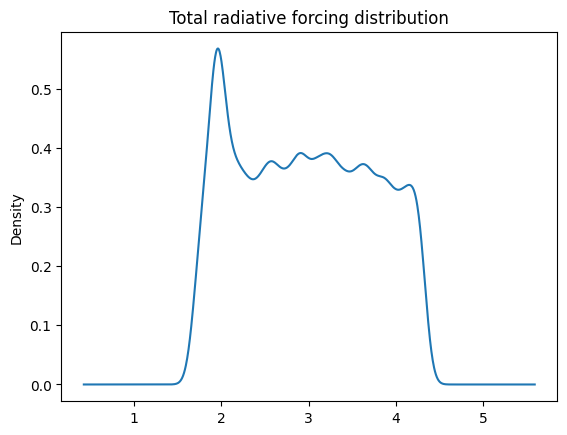

In [9]:
df_melted['total_radiative_forcing'].plot(kind='kde', title='Total radiative forcing distribution')

Here, we try to spot years that would be anormal.

In [10]:
df_2016 = df_melted[df_melted['time'] == 2015]
df_2016

,time,REGIONS 35 I,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,equation,total_damage
325,2015.0,AUSTRIA,-0.452698,48486.425036,2.117411,0.000000,0,1.050761,3.786850e+05,0.000000,define_tot_eq_define_total_impact,0.000000
326,2015.0,BELGIUM,-0.452698,48486.425036,2.117411,0.427727,0,1.050761,4.580816e+05,25320.161597,define_tot_eq_define_total_impact,634.217873
327,2015.0,BULGARIA,-0.452698,48486.425036,2.117411,0.023408,0,1.050761,4.934207e+04,4481.498197,define_tot_eq_define_total_impact,3.738644
328,2015.0,CROATIA,-0.452698,48486.425036,2.117411,0.058584,0,1.050761,4.937873e+04,7742.439308,define_tot_eq_define_total_impact,9.363636
329,2015.0,CYPRUS,-0.452698,48486.425036,2.117411,0.181885,0,1.050761,2.025158e+04,15209.898854,define_tot_eq_define_total_impact,11.922954
...,...,...,...,...,...,...,...,...,...,...,...,...
185371,2015.0,INDIA,-0.913396,17151.313387,2.117411,0.001996,14,1.050761,2.073712e+06,1033.161498,witness_tot_eq_witness_total_impact,26.790780
185372,2015.0,LATAM,-0.913396,17151.313387,2.117411,0.039670,14,1.050761,3.228709e+06,6137.085294,witness_tot_eq_witness_total_impact,829.007924
185373,2015.0,RUSSIA,-0.913396,17151.313387,2.117411,0.045852,14,1.050761,1.391604e+06,6690.368533,witness_tot_eq_witness_total_impact,412.993969
185374,2015.0,USMCA,-0.913396,17151.313387,2.117411,0.622819,14,1.050761,2.091227e+07,31676.133804,witness_tot_eq_witness_total_impact,84301.638297


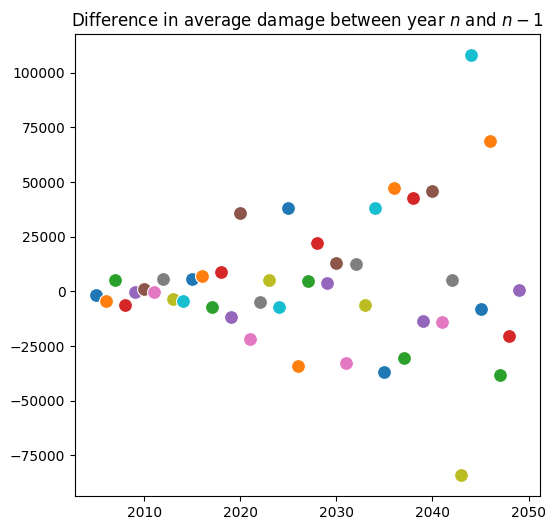

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))

for year in range(2005, 2050):

    dif = df_melted.loc[df_melted['time'] == year+1, 'total_damage'].mean() - df_melted.loc[df_melted['time'] == year, 'total_damage'].mean()
    sns.scatterplot(x=[year], y=[dif], ax=ax, s=100, label=f'{year} - {year+1}', legend=False)


plt.title('Difference in average damage between year $n$ and $n-1$')
plt.show()

Since there is obviously something happening in 2015 and we do not understand why, we will remove the year 2015. 

In [12]:
#df_melted = df_melted[~df_melted['time'].isin([2015, 2043,  2048])] It disappeared in later runs

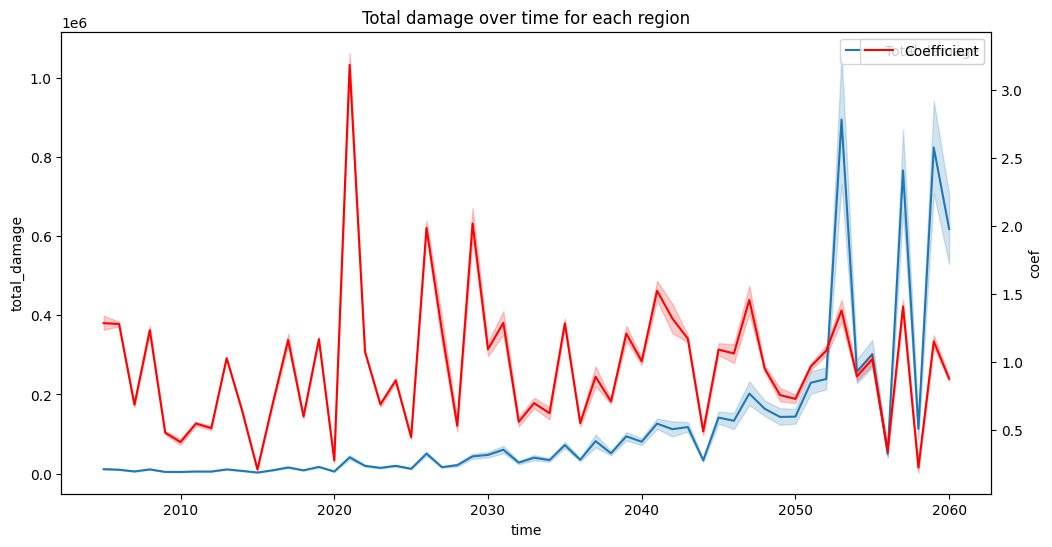

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))


#df_melted_grouped_region = df_melted.groupby(['time', 'REGIONS 35 I']).mean().reset_index()
sns.lineplot(data=df_melted, x='time', y='total_damage', legend=True, estimator='mean', ax=ax, label='Total damage')
ax2 = ax.twinx()
sns.lineplot(data=df_melted, x='time', y='coef', legend=True, estimator='mean', ax=ax2, color='red', label='Coefficient')

plt.title('Total damage over time for each region')
plt.legend()
#ax.set_yscale('log')

plt.show()  

### Checking where and when the damages are the higher

This step serves to check irregularities in the experimental setup. 

In [14]:
df_melted['Run'].unique()

array([ 0,  1, ..., 13, 14])

Plotting run 4
Plotting run 11
Plotting run 1
Plotting run 2
Plotting run 3
Plotting run 14
Plotting run 13
Plotting run 12
Plotting run 0
Plotting run 10
Plotting run 8
Plotting run 5
Plotting run 7
Plotting run 9
Plotting run 6


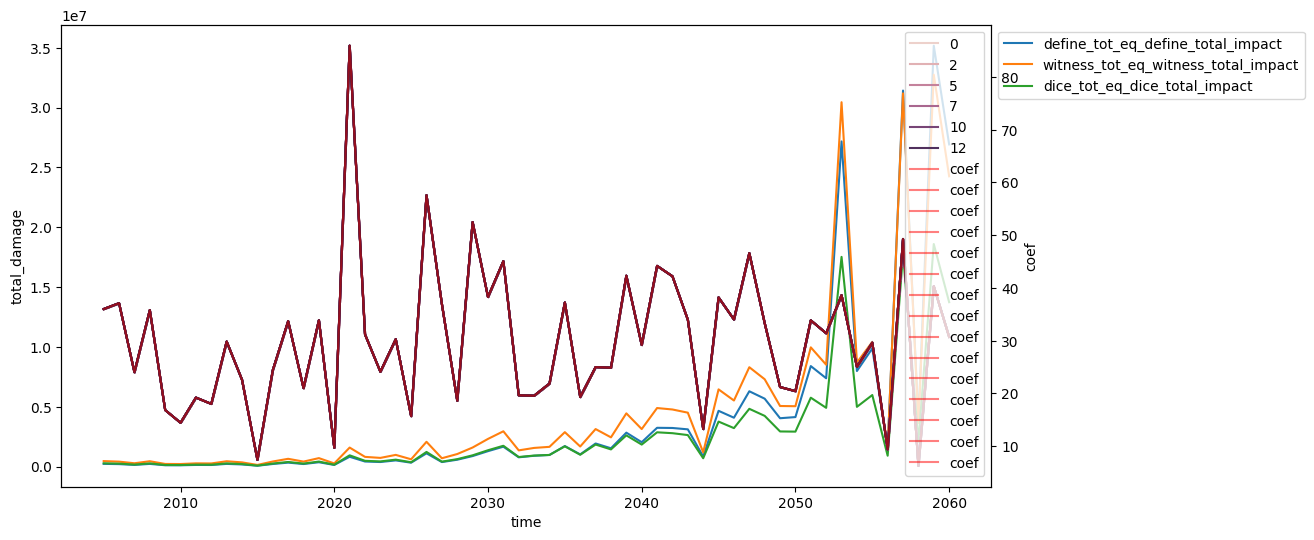

In [15]:


hd_country = df_melted.groupby(['time', 'total_radiative_forcing', 'equation', 'Run']).sum().reset_index().sort_values(ascending=False, by='total_damage')

fig, ax = plt.subplots(figsize=(12, 6))
ax2 = ax.twinx()
sns.lineplot(data=hd_country, x='time', y='coef', hue='Run')


for run in hd_country['Run'].unique():

    hd_country = hd_country[hd_country['Run']==run]
    print(f'Plotting run {run}')

    sns.lineplot(data=hd_country, x='time', y='total_damage', hue='equation', estimator='mean', ax=ax)

    sns.lineplot(data=hd_country, x='time', y='coef', label='coef', estimator='mean', ax=ax2, color='red', alpha=0.5)

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [16]:
ds = xr.open_dataset('../../../results/batch/run_ds_19_07_3.nc')

In [17]:
ds.average_disposable_income_per_capita

<xarray.DataArray 'average_disposable_income_per_capita' (Run: 10, time: 6,
                                                          region: 35)> Size: 17kB
[2100 values with dtype=float64]
Coordinates:
  * region   (region) <U14 2kB 'AUSTRIA' 'BELGIUM' 'BULGARIA' ... 'USMCA' 'LROW'
  * time     (time) float64 48B 2.005e+03 2.006e+03 ... 2.009e+03 2.01e+03
  * Run      (Run) int32 40B 0 1 2 3 4 5 6 7 8 9
Attributes: (6)

In [18]:
ds.average_disposable_income_per_capita.mean(dim=['time', 'region'])

<xarray.DataArray 'average_disposable_income_per_capita' (Run: 10)> Size: 80B
1.323e+04 1.323e+04 1.323e+04 1.323e+04 ... 1.323e+04 1.323e+04 1.323e+04
Coordinates:
  * Run      (Run) int32 40B 0 1 2 3 4 5 6 7 8 9

In [19]:
ds.extra_extra_gdp_modifyer.mean(dim=['region'])

<xarray.DataArray 'extra_extra_gdp_modifyer' (Run: 10, time: 6)> Size: 480B
1.661 inf inf inf inf inf 0.5415 ... 0.5741 inf inf 0.2836 0.8027 0.5085 inf
Coordinates:
  * time     (time) float64 48B 2.005e+03 2.006e+03 ... 2.009e+03 2.01e+03
  * Run      (Run) int32 40B 0 1 2 3 4 5 6 7 8 9

In [20]:
custom_palette = sns.color_palette("Pastel2", 10)  # Vous pouvez choisir d'autres palettes comme 'Set2', 'Dark2', 'Pastel1', etc.
custom_palette

[(0.7019607843137254, 0.8862745098039215, 0.803921568627451),
 (0.9921568627450981, 0.803921568627451, 0.6745098039215687),
 (0.796078431372549, 0.8352941176470589, 0.9098039215686274),
 (0.9568627450980393, 0.792156862745098, 0.8941176470588236),
 (0.9019607843137255, 0.9607843137254902, 0.788235294117647),
 (1.0, 0.9490196078431372, 0.6823529411764706),
 (0.9450980392156862, 0.8862745098039215, 0.8),
 (0.8, 0.8, 0.8),
 (0.7019607843137254, 0.8862745098039215, 0.803921568627451),
 (0.9921568627450981, 0.803921568627451, 0.6745098039215687)]

In [21]:
ds = xr.open_dataset('../../../results/batch/run_ds_19_07_2.nc')

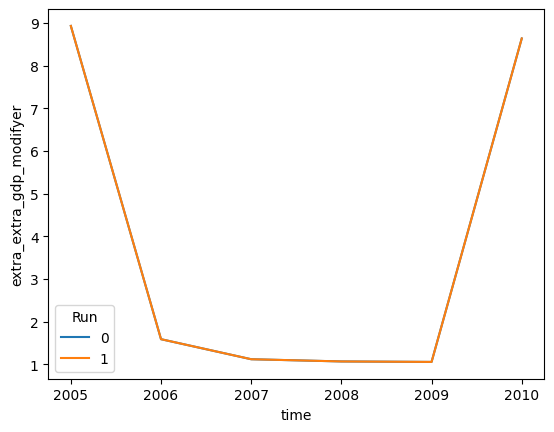

In [22]:
ds.extra_extra_gdp_modifyer.median(dim='REGIONS 35 I').plot(hue='Run')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


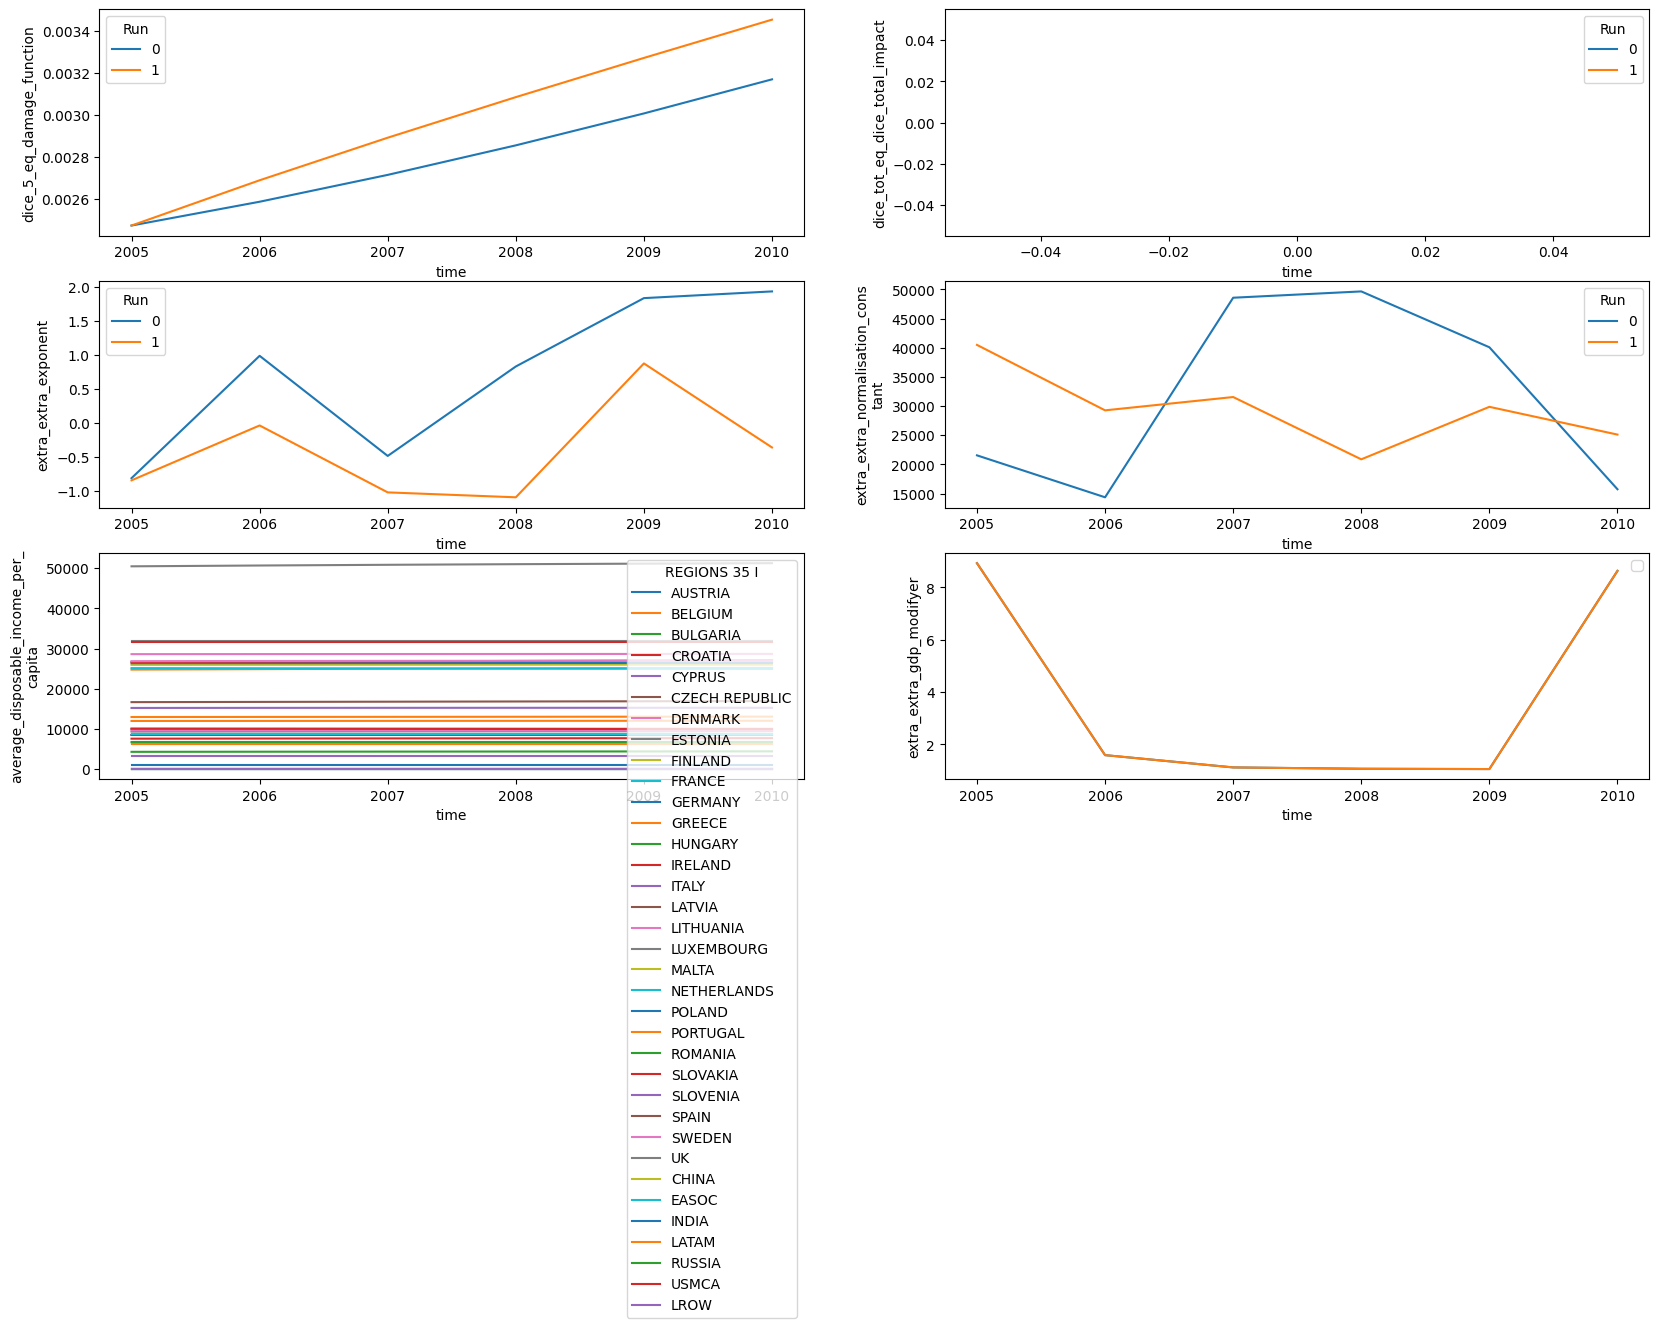

In [23]:
fig, ax = plt.subplots(3, 2, figsize=(20, 10))

plt.set_cmap('plasma')

ds.dice_5_eq_damage_function.plot(hue='Run', ax=ax[0,0])
ds.dice_tot_eq_dice_total_impact.sum(dim='REGIONS 35 I').plot(hue='Run', ax=ax[0,1])
ds.extra_extra_exponent.plot(hue='Run', ax=ax[1,0])
ds.extra_extra_normalisation_constant.plot(hue='Run', ax=ax[1,1])
ds.average_disposable_income_per_capita.mean(dim='Run').plot(hue='REGIONS 35 I', ax=ax[2,0])
ds.extra_extra_gdp_modifyer.median(dim='REGIONS 35 I').plot(hue='Run', ax=ax[2,1])


plt.legend()


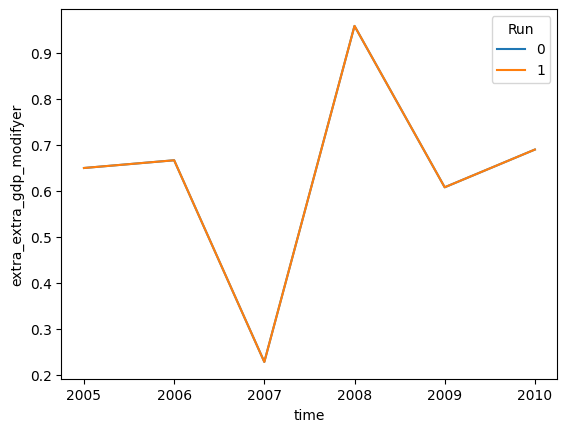

In [24]:
ds.extra_extra_gdp_modifyer.min(dim='REGIONS 35 I').plot(hue='Run')

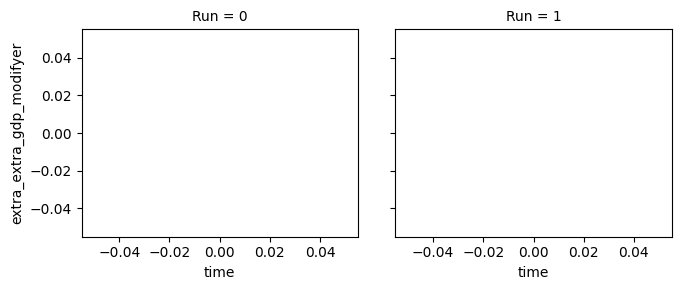

In [25]:
ds.extra_extra_gdp_modifyer.mean(dim='REGIONS 35 I').plot(col='Run')

In [26]:
# Drop infinite values
infinites = df_melted[(df_melted['total_damage'] == np.inf) | (df_melted['total_damage'] == -np.inf)]
df_melted.replace([np.inf, -np.inf], np.nan, inplace=True)
infinites.size

0

In [27]:
# Save the dataframe to a csv file to access it from the other notebook
df_melted.to_csv('df_melted.csv', index=False)